In [14]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "2" 


import torch_geometric
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, TopKPooling, global_mean_pool, GraphUNet
from torch_geometric.data import Batch
from torch_geometric.utils import to_dense_adj
from tqdm import tqdm
import networkx as nx
from torch_geometric.utils import to_networkx

from utils.data import GraphDataModule, save_prediction
from utils.training import train_model
from utils.metrics import evaluate_model

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [3]:
data_module = GraphDataModule("./data", num_workers=1)
train_loader = data_module.train_dataloader()
val_loader = data_module.val_dataloader()

Time taken to load ./data\hr_train.csv: 3.5909507274627686 seconds
Time taken to load ./data\lr_train.csv: 0.8131844997406006 seconds
Time taken to load ./data\lr_test.csv: 0.48959922790527344 seconds


Converting vectors to graphs: 100%|██████████| 112/112 [00:00<00:00, 1017.34it/s]


In [4]:
batch, target_batch = next(iter(train_loader))
example = batch[0]
example_target = target_batch[0]

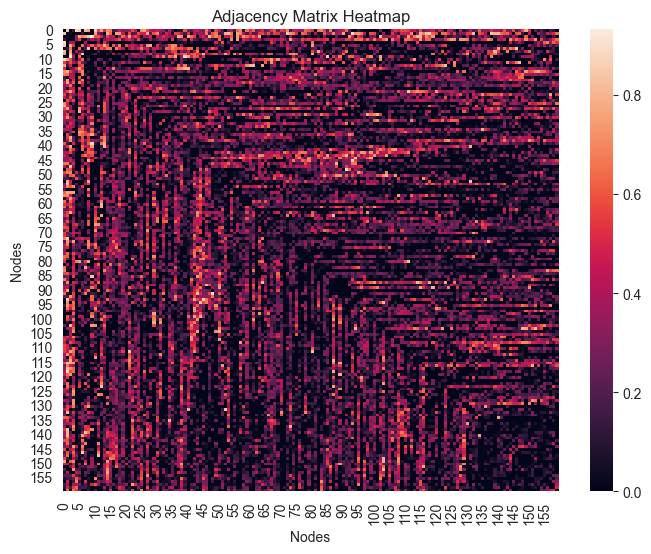

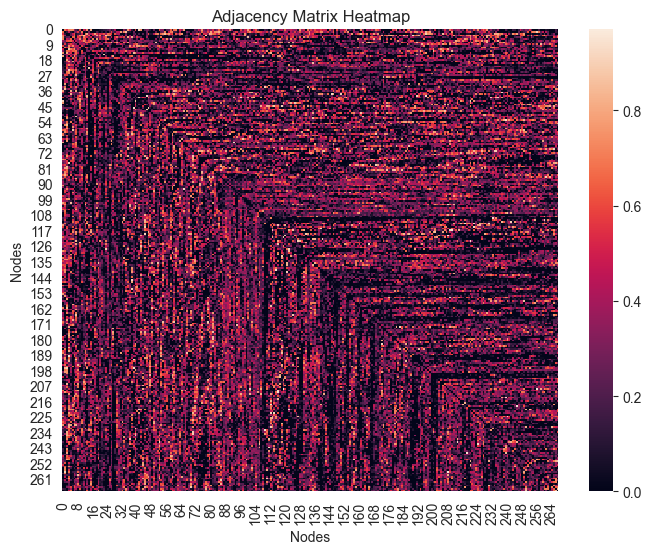

In [11]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from torch_geometric.data import Data
from torch_geometric.utils import to_dense_adj


# Use PyG's to_dense_adj to get adjacency matrix
adj_matrix = to_dense_adj(example.edge_index, edge_attr=example.edge_attr, max_num_nodes=example.num_nodes)[0]

# Convert to numpy for visualization
adj_matrix_np = adj_matrix.numpy()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(adj_matrix_np, fmt=".0f")
plt.title("Adjacency Matrix Heatmap")
plt.xlabel("Nodes")
plt.ylabel("Nodes")

# Use PyG's to_dense_adj to get adjacency matrix
adj_matrix = to_dense_adj(example_target.edge_index, edge_attr=example_target.edge_attr, max_num_nodes=example_target.num_nodes)[0]

# Convert to numpy for visualization
adj_matrix_np = adj_matrix.numpy()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(adj_matrix_np, fmt=".0f")
plt.title("Adjacency Matrix Heatmap")
plt.xlabel("Nodes")
plt.ylabel("Nodes")
plt.show()


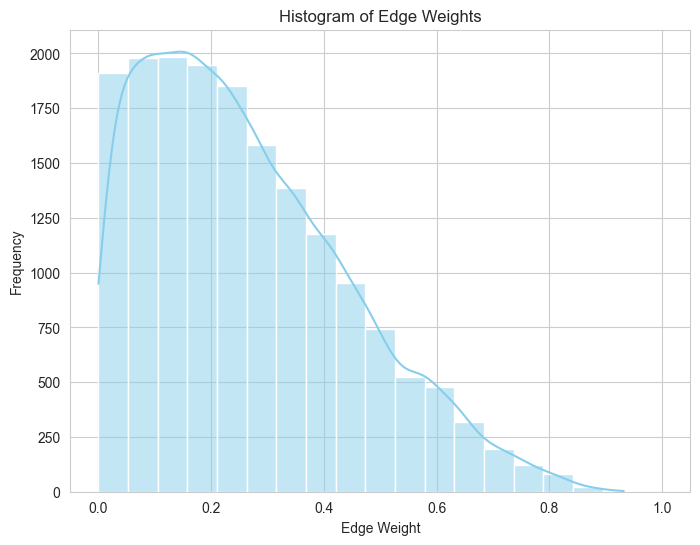

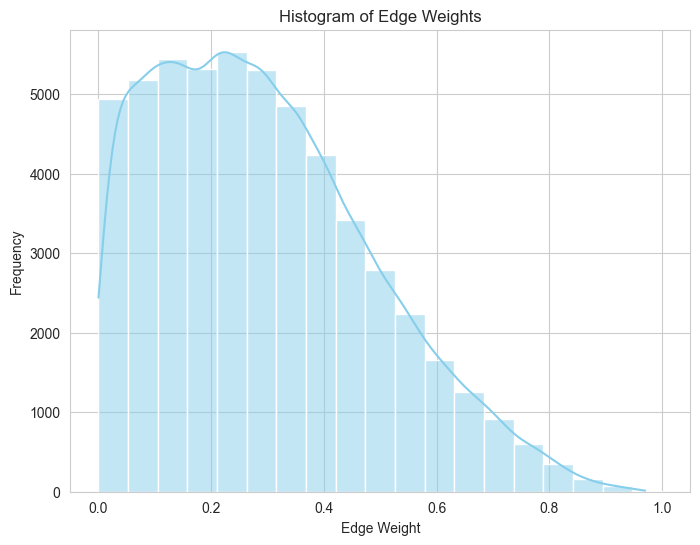

In [8]:
bins = np.linspace(0,1,20)

plt.figure(figsize=(8, 6))
sns.histplot(example.edge_attr.numpy(), bins=bins, kde=True, color='skyblue')
plt.title("Histogram of Edge Weights")
plt.xlabel("Edge Weight")
plt.ylabel("Frequency")
plt.grid(True)

plt.figure(figsize=(8, 6))
sns.histplot(example_target.edge_attr.numpy(), bins=bins, kde=True, color='skyblue')
plt.title("Histogram of Edge Weights")
plt.xlabel("Edge Weight")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [12]:
def filter_edges(data, threshold):
    # Mask to keep only edges with weight above threshold
    mask = data.edge_attr > threshold
    
    # Filter edge_index and edge_attr
    edge_index = data.edge_index[:, mask]
    edge_attr = data.edge_attr[mask]
    
    # Return new Data object with filtered edges
    return Data(x=data.x, edge_index=edge_index, edge_attr=edge_attr)

In [31]:
filt_e = filter_edges(example, 0.7)
filt_et = filter_edges(example_target, 0.7)

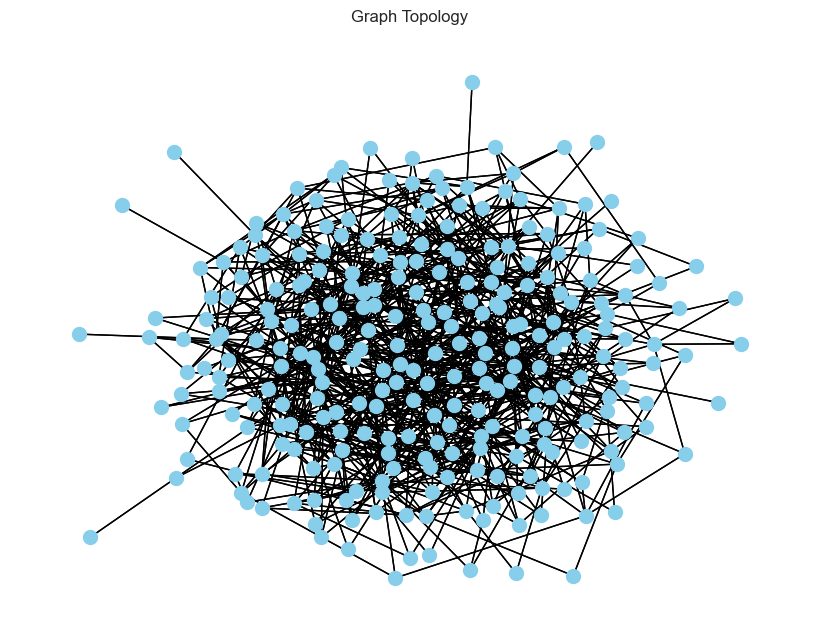

In [32]:
G = to_networkx(filt_et, edge_attrs=["edge_attr"])

# Plot the filtered graph
plt.figure(figsize=(8, 6))
pos = nx.kamada_kawai_layout(G)  # Layout for visualization
nx.draw(G, pos, with_labels=False, arrows=False, node_color="skyblue", node_size=100, font_size=5, font_color="black")
plt.title(f"Graph Topology")
plt.show()